In [ ]:
# Lesson 3 — Logistic Regression

An outline of this lecture includes:
- Linear Regression Recap
- Locally Weighted Regression
- Probabilistic Interpretation
- Logistic Regression
- Newton's method



### Imports & Random Seed


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets  # datasets only

np.random.seed(0)



### Data Loading & Preprocessing

We use the **breast cancer** dataset from `sklearn.datasets`, a binary classification problem with
30 features.  We standardize the features to have zero mean and unit variance and map
the labels to 0 and 1.  Then we add an intercept term.


In [15]:
X_raw, y_raw = datasets.load_breast_cancer(return_X_y=True)

# Standardize features
X = (X_raw - X_raw.mean(axis=0)) / X_raw.std(axis=0)
y = y_raw.reshape(-1, 1)

# Number of examples and features
m, n = X.shape

# Add intercept column
Xb = np.hstack([np.ones((m, 1)), X])  # shape (m, n+1)

print(f"Dataset: {m} examples, {n} features (after standardization).")



Dataset: 569 examples, 30 features (after standardization).


## Linear Regression (Recap)

In [16]:
## 1. Linear Regression (Recap)

### Hypothesis:
#### \[h_\theta(x) = \theta^T x\]

### Objective (MSE):
#### \[J(\theta) = \frac{1}{2m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})^2\]


In [17]:
# %%
def mse_loss(Xb, y, theta):
    errors = Xb @ theta - y
    return np.mean(errors ** 2)

def mse_gradient(Xb, y, theta):
    m = Xb.shape[0]
    return (2 / m) * Xb.T @ (Xb @ theta - y)

## Locally Weighted Linear Regression (LWLR)

In [18]:
# %%
def lwlr_predict(Xb, y, x0, tau):
    W = np.exp(-np.sum((Xb - x0) ** 2, axis=1) / (2 * tau ** 2))
    W = np.diag(W)
    theta = np.linalg.pinv(Xb.T @ W @ Xb) @ Xb.T @ W @ y
    return x0 @ theta


### Logistic Regression (Binary Classification)

In [19]:
# %%
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def log_loss(Xb, y, theta):
    h = sigmoid(Xb @ theta)
    h = np.clip(h, 1e-15, 1 - 1e-15)
    return -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))

def log_gradient(Xb, y, theta):
    m = Xb.shape[0]
    return (1 / m) * Xb.T @ (sigmoid(Xb @ theta) - y)


## Training Logistic Regression (Gradient Descent)


In [20]:
# %%
def gradient_descent_logistic(Xb, y, lr=0.1, epochs=2000):
    theta = np.zeros((Xb.shape[1], 1))
    history = []
    for _ in range(epochs):
        history.append(log_loss(Xb, y, theta))
        theta -= lr * log_gradient(Xb, y, theta)
    history.append(log_loss(Xb, y, theta))
    return theta, history


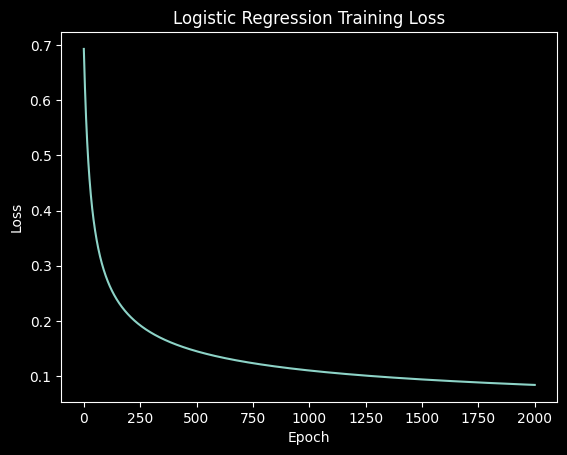

In [21]:
# %%
# Synthetic classification data
np.random.seed(0)
X = np.random.randn(200, 2)
y = (X[:, 0] + X[:, 1] > 0).astype(int).reshape(-1, 1)

X = (X - X.mean(axis=0)) / X.std(axis=0)
Xb = np.c_[np.ones((X.shape[0], 1)), X]

theta_gd, history_gd = gradient_descent_logistic(Xb, y)

plt.plot(history_gd)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Logistic Regression Training Loss")
plt.show()


## Newton’s Method for Logistic Regression

In [22]:
# %%
def log_hessian(Xb, theta):
    h = sigmoid(Xb @ theta)
    r = (h * (1 - h)).reshape(-1)
    XR = Xb * r[:, None]
    return (1 / Xb.shape[0]) * Xb.T @ XR


In [23]:
# %%
def newtons_method(Xb, y, iters=20, damping=1e-4):
    theta = np.zeros((Xb.shape[1], 1))
    history = []
    I = np.eye(Xb.shape[1])
    for _ in range(iters):
        history.append(log_loss(Xb, y, theta))
        g = log_gradient(Xb, y, theta)
        H = log_hessian(Xb, theta)
        theta -= np.linalg.solve(H + damping * I, g)
    history.append(log_loss(Xb, y, theta))
    return theta, history


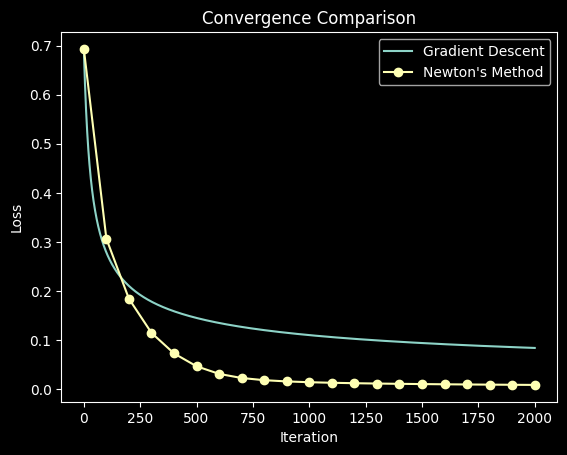

In [24]:
theta_nt, history_nt = newtons_method(Xb, y)

plt.plot(history_gd, label="Gradient Descent")
plt.plot(
    np.linspace(0, len(history_gd)-1, len(history_nt)),
    history_nt,
    marker="o",
    label="Newton's Method",
)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Convergence Comparison")
plt.show()


Gradient Descent:
- Uses only gradients
- Scales well to large datasets
- Slower convergence, needs learning rate tuning
- Use when: data or feature dimension is large

Newton’s Method:
- Uses gradient + Hessian (curvature)
- Converges much faster, no learning rate
- Expensive and unstable for large
- Use when: problem is convex and dimension is small/medium

Locally Weighted Regression:
- Fits a model per query point
- Captures local nonlinearity
- Very slow at prediction time
- Use when: dataset is small and locality matters

Key insight:
- Linear regression = Gaussian MLE
- Logistic regression = Bernoulli MLE
- Newton beats GD when curvature is affordable